#**Importing Libraries and Reading the Dataset**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

In [ ]:
hd = pd.read_csv('/content/StudentPerformanceFactors.csv')

#**Data Inception**

In [ ]:
hd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               6607 non-null   int64 
 1   Attendance                  6607 non-null   int64 
 2   Parental_Involvement        6607 non-null   object
 3   Access_to_Resources         6607 non-null   object
 4   Extracurricular_Activities  6607 non-null   object
 5   Sleep_Hours                 6607 non-null   int64 
 6   Previous_Scores             6607 non-null   int64 
 7   Motivation_Level            6607 non-null   object
 8   Internet_Access             6607 non-null   object
 9   Tutoring_Sessions           6607 non-null   int64 
 10  Family_Income               6607 non-null   object
 11  Teacher_Quality             6529 non-null   object
 12  School_Type                 6607 non-null   object
 13  Peer_Influence              6607 non-null   obje

In [ ]:
hd.describe()

,Hours_Studied,Attendance,Sleep_Hours,Previous_Scores,Tutoring_Sessions,Physical_Activity,Exam_Score
count,6607.000000,6607.000000,6607.00000,6607.000000,6607.000000,6607.000000,6607.000000
mean,19.975329,79.977448,7.02906,75.070531,1.493719,2.967610,67.235659
std,5.990594,11.547475,1.46812,14.399784,1.230570,1.031231,3.890456
min,1.000000,60.000000,4.00000,50.000000,0.000000,0.000000,55.000000
25%,16.000000,70.000000,6.00000,63.000000,1.000000,2.000000,65.000000
50%,20.000000,80.000000,7.00000,75.000000,1.000000,3.000000,67.000000
75%,24.000000,90.000000,8.00000,88.000000,2.000000,4.000000,69.000000
max,44.000000,100.000000,10.00000,100.000000,8.000000,6.000000,101.000000


In [ ]:
!pip install ydata_profiling
from ydata_profiling import ProfileReport
profile = ProfileReport(hd)
profile.to_file("studentPredict.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 20/20 [00:00<00:00, 31.53it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

#**Handling Missing Values**

In [ ]:
hd.isnull().sum()


,0
Hours_Studied,0
Attendance,0
Parental_Involvement,0
Access_to_Resources,0
Extracurricular_Activities,0
Sleep_Hours,0
Previous_Scores,0
Motivation_Level,0
Internet_Access,0
Tutoring_Sessions,0


In [ ]:
for col in hd.columns:
    if hd[col].dtype == "object":
        hd[col].fillna(hd[col].mode()[0], inplace=True)
    else:
        hd[col].fillna(hd[col].median(), inplace=True)

/tmp/ipython-input-1822843583.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  hd[col].fillna(hd[col].median(), inplace=True)
/tmp/ipython-input-1822843583.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

In [ ]:
hd.isnull().sum()

,0
Hours_Studied,0
Attendance,0
Parental_Involvement,0
Access_to_Resources,0
Extracurricular_Activities,0
Sleep_Hours,0
Previous_Scores,0
Motivation_Level,0
Internet_Access,0
Tutoring_Sessions,0


#**Data Visualization**

These plots will help me in:


*   See distribution of exam scores
*   Find correlations (hours studied, attendance, etc.)
*   Understand categorical effects (gender, school type, parental involvement)
*   Spot patterns/outliers


1.   Distribution of Exam Scores



Original shape: (6607, 20)
After removing outliers: (6503, 20)


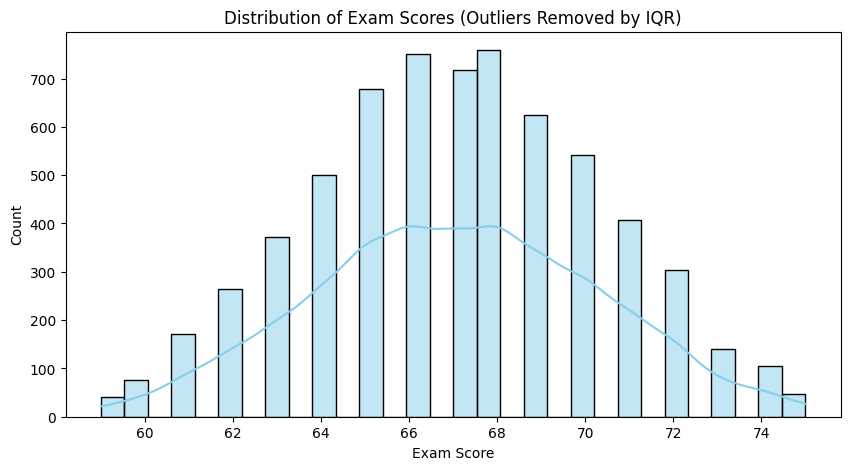

In [ ]:
# Detect outliers using IQR method
Q1 = hd["Exam_Score"].quantile(0.25)
Q3 = hd["Exam_Score"].quantile(0.75)
IQR = Q3 - Q1
# Keep only non-outliers
hd_no_outliers = hd[(hd["Exam_Score"] >= Q1 - 1.5*IQR) &
                    (hd["Exam_Score"] <= Q3 + 1.5*IQR)]
print("Original shape:", hd.shape)
print("After removing outliers:", hd_no_outliers.shape)
plt.figure(figsize=(10,5))
sns.histplot(hd_no_outliers["Exam_Score"], kde=True, bins=30, color="skyblue")
plt.title("Distribution of Exam Scores (Outliers Removed by IQR)")
plt.xlabel("Exam Score")
plt.ylabel("Count")
plt.show()



2. Hours Studied vs Exam Score

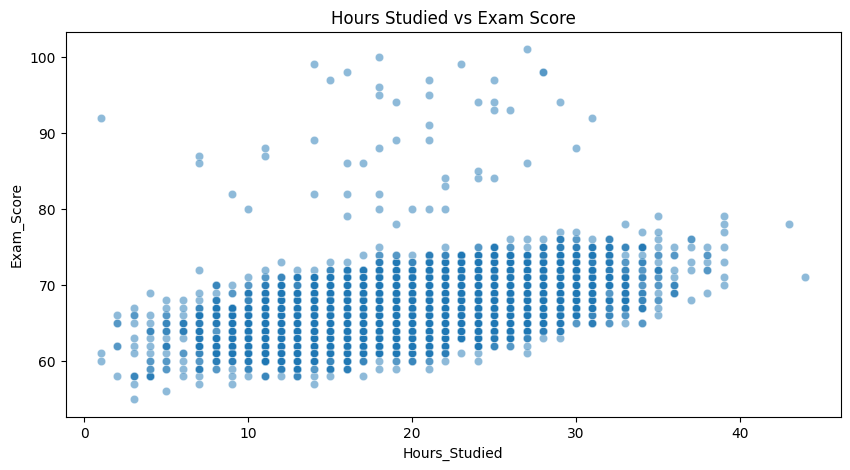

In [ ]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=hd, x="Hours_Studied", y="Exam_Score", alpha=0.5)
plt.title("Hours Studied vs Exam Score")
plt.show()


3. Correlation Heatmap (numeric only)

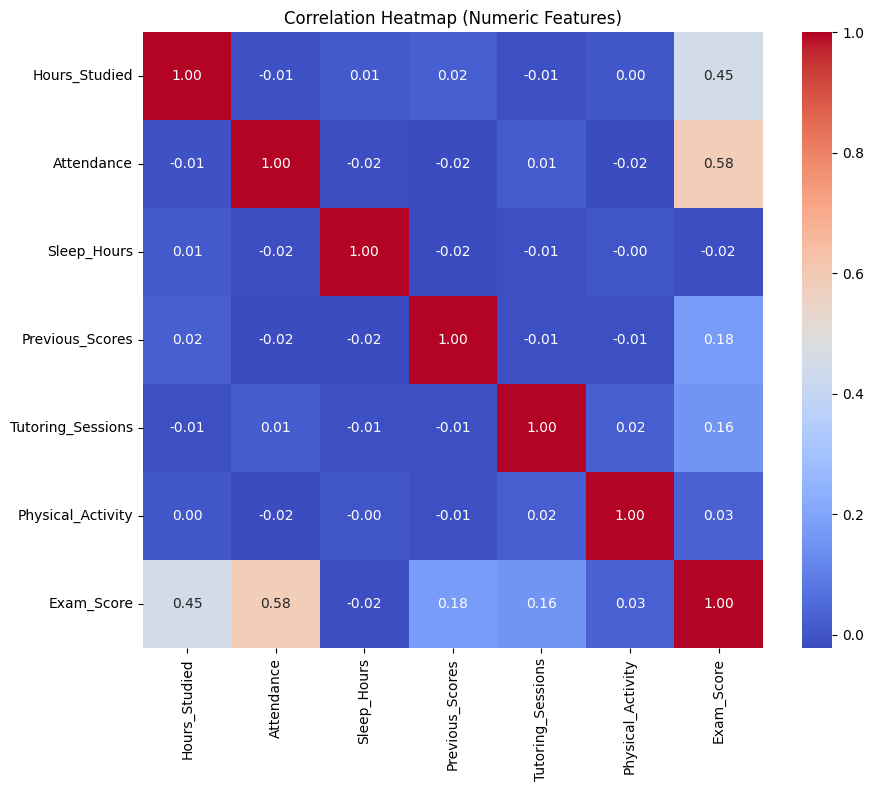

In [ ]:
plt.figure(figsize=(10,8))
numeric_hd = hd.select_dtypes(include=np.number) # Select only numeric columns
sns.heatmap(numeric_hd.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

4. Boxplot: Categorical vs Exam Score

/tmp/ipython-input-2923263535.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y="Exam_Score", data=hd, palette="Set2")
/tmp/ipython-input-2923263535.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y="Exam_Score", data=hd, palette="Set2")
/tmp/ipython-input-2923263535.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y="Exam_Score", data=hd, palette="Set2")
/tmp/ipython-input-2923263535.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `

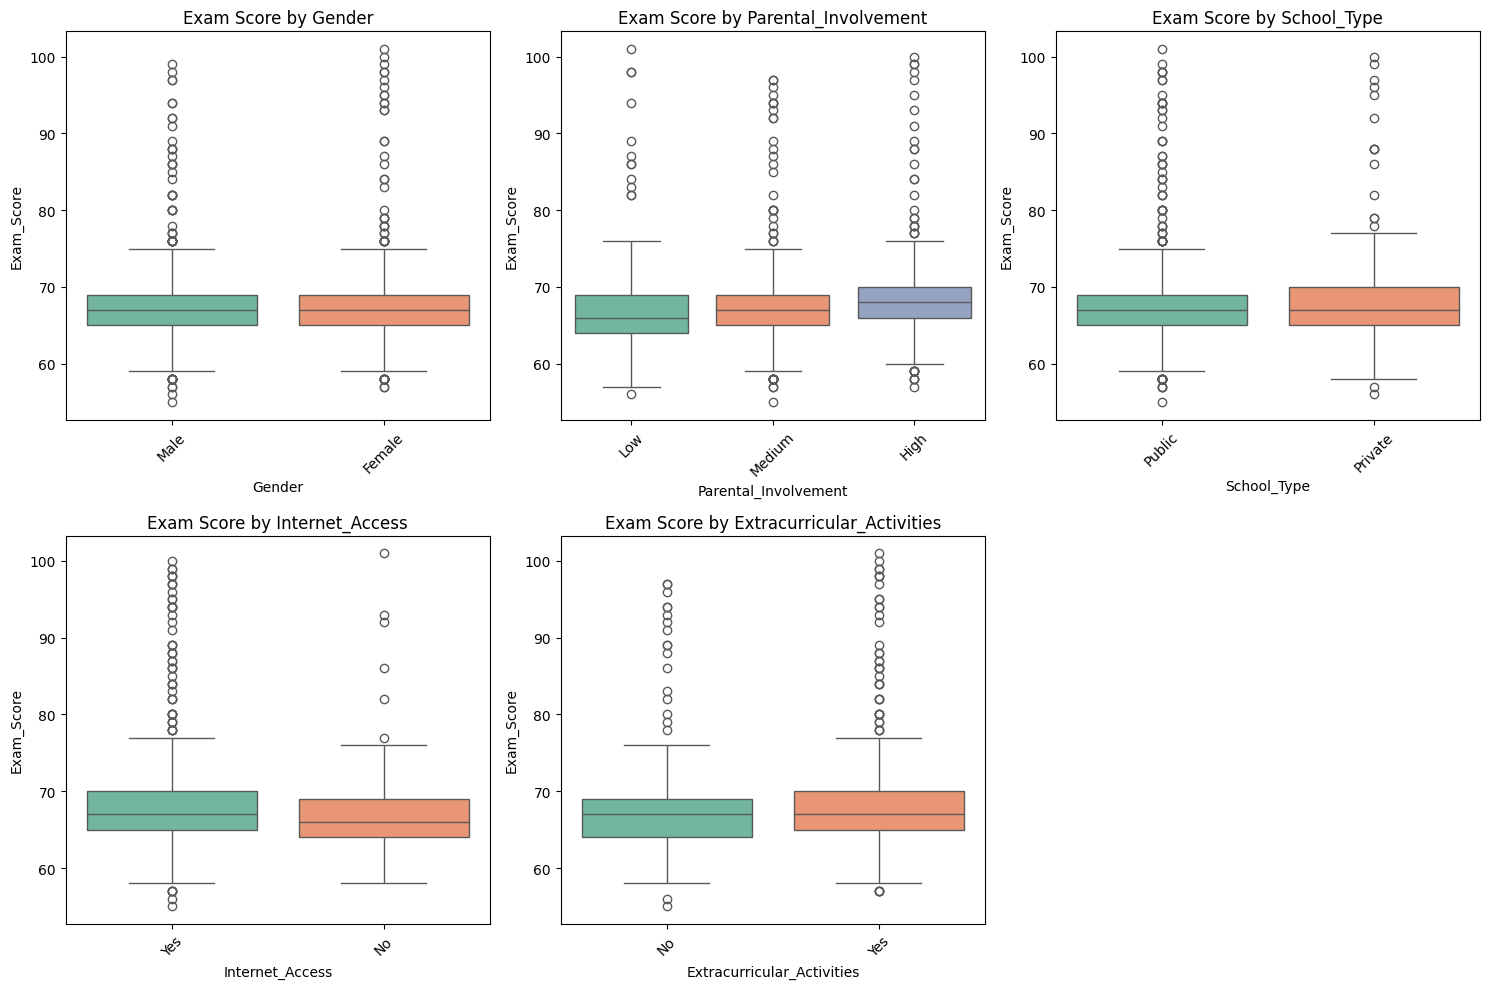

In [ ]:
categorical_cols = ["Gender", "Parental_Involvement", "School_Type","Internet_Access", "Extracurricular_Activities"]
n = len(categorical_cols)
rows = (n + 2) // 3
cols = 3
plt.figure(figsize=(5*cols, 5*rows))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(rows, cols, i)
    sns.boxplot(x=col, y="Exam_Score", data=hd, palette="Set2")
    plt.title(f"Exam Score by {col}")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


5. Hours Studied by School Type

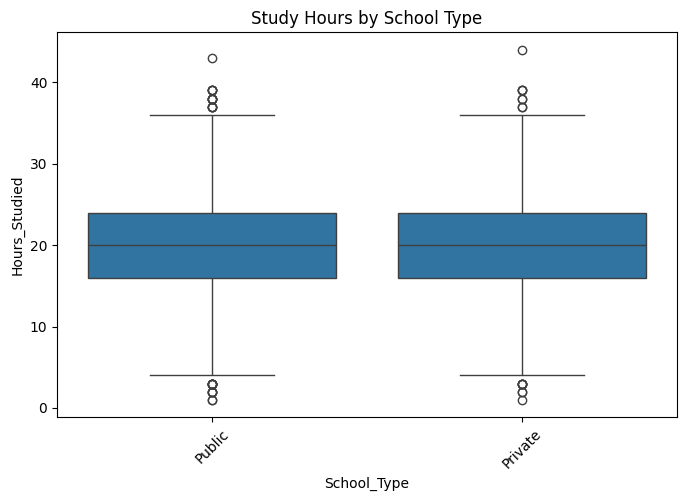

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x="School_Type", y="Hours_Studied", data=hd)
plt.title("Study Hours by School Type")
plt.xticks(rotation=45)
plt.show()

6. Pairplot of Key Features

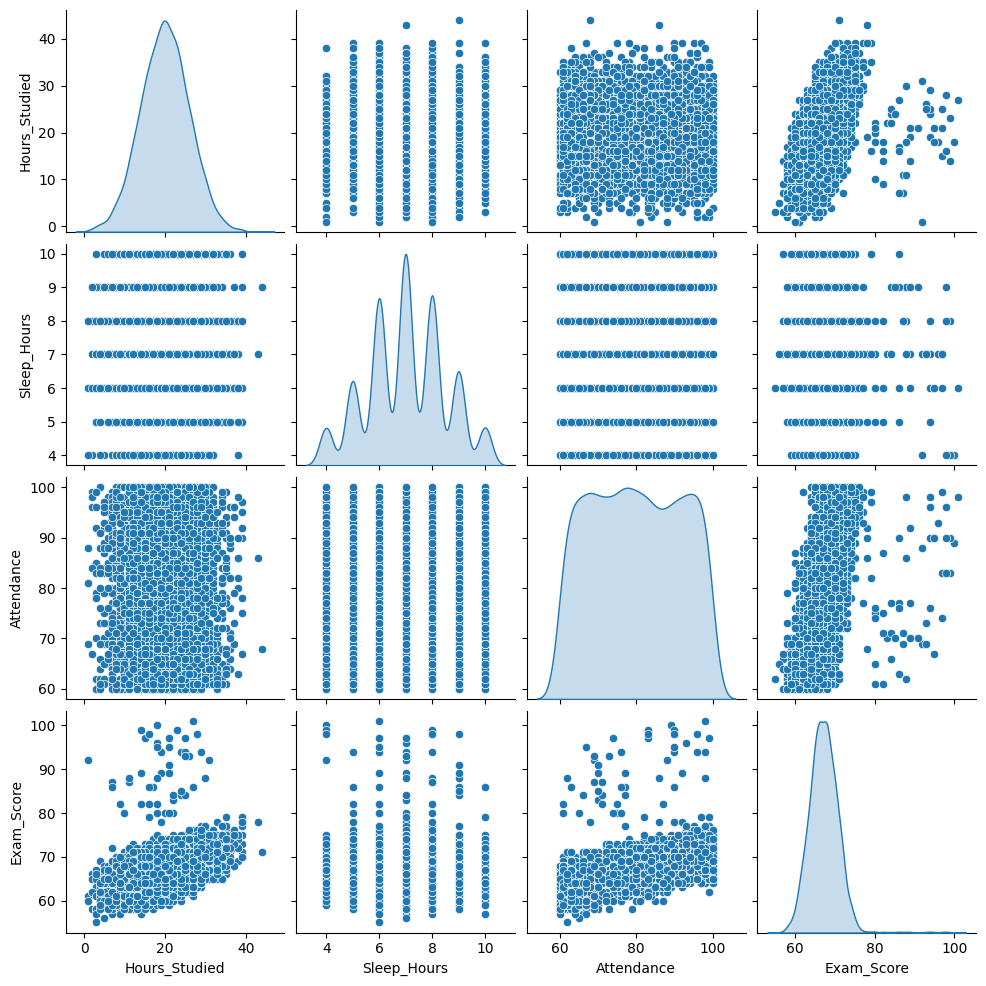

In [ ]:
sns.pairplot(hd[["Hours_Studied", "Sleep_Hours", "Attendance", "Exam_Score"]], diag_kind="kde")
plt.show()

#**Splitting the Data**

In [ ]:
X = hd_no_outliers.drop("Exam_Score", axis=1)
y = hd_no_outliers["Exam_Score"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#**Encoding and Scaling**

In [ ]:
# --- Preprocessing ---
num_features = X.select_dtypes(include=np.number).columns
cat_features = X.select_dtypes(exclude=np.number).columns

X_train_num = X_train[num_features]
X_test_num  = X_test[num_features]

X_train_cat = X_train[cat_features]
X_test_cat  = X_test[cat_features]

# --- Scale Numeric ---
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled  = scaler.transform(X_test_num)

print("Means after scaling:", np.mean(X_train_num_scaled, axis=0))
print("Stds  after scaling:", np.std(X_train_num_scaled, axis=0, ddof=0))

# --- Encode Categorical ---
encoder = OneHotEncoder(drop="first", handle_unknown="ignore")
X_train_cat_enc = encoder.fit_transform(X_train_cat)
X_test_cat_enc  = encoder.transform(X_test_cat)

# --- Concatenate Back ---
X_train_final = np.hstack([X_train_num_scaled, X_train_cat_enc.toarray()]) # Convert sparse matrix to dense array
X_test_final  = np.hstack([X_test_num_scaled, X_test_cat_enc.toarray()])   # Convert sparse matrix to dense array

print("Final Train Shape:", X_train_final.shape)
print("Final Test Shape :", X_test_final.shape)

Means after scaling: [ 1.98055934e-17 -4.65089968e-16 -2.41764829e-16  1.29077833e-16
  6.00997316e-17  1.56737368e-16]
Stds  after scaling: [1. 1. 1. 1. 1. 1.]
Final Train Shape: (5202, 27)
Final Test Shape : (1301, 27)


#**Fitting Linear Regression Model**

In [ ]:
reg = LinearRegression()
reg.fit(X_train_final, y_train)

# Predict
y_pred = reg.predict(X_train_final)

# Evaluation
mae = mean_absolute_error(y_train, y_pred)
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
r2 = r2_score(y_train, y_pred)

print("MAE:", mae)
print("RMSE:", rmse)
print("R²:", r2)


MAE: 0.27351061832350154
RMSE: 0.32594738351491326
R²: 0.9899569049376326


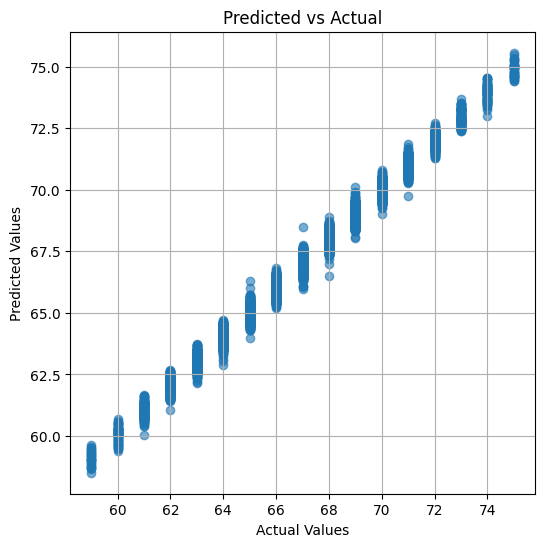

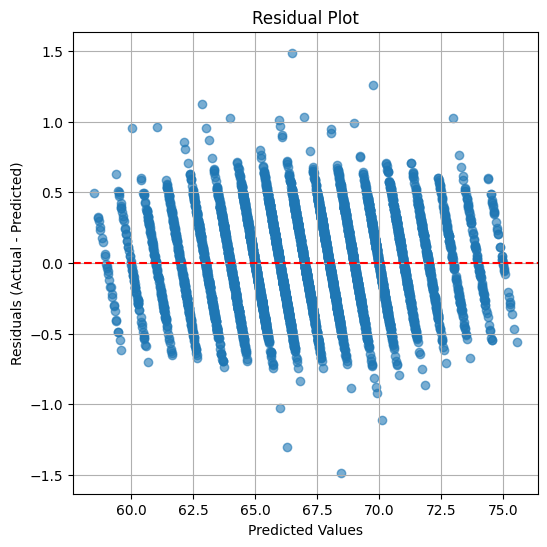

In [ ]:
# --- 1. Predicted vs Actual ---
plt.figure(figsize=(6,6))
plt.scatter(y_train, y_pred, alpha=0.6)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual")
plt.grid(True)
plt.show()

# --- 2. Residual Plot ---
residuals = y_train - y_pred
plt.figure(figsize=(6,6))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot")
plt.grid(True)
plt.show()

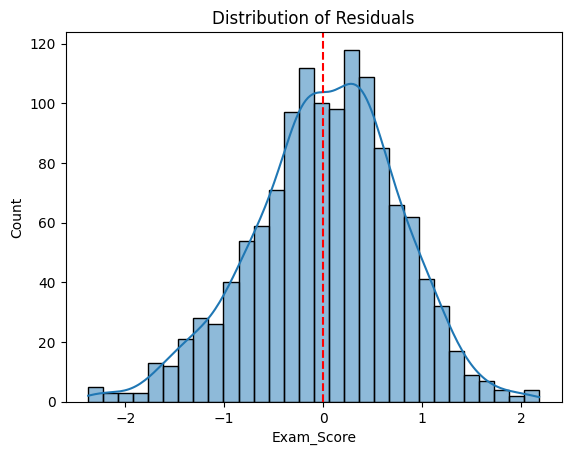

In [ ]:
sns.histplot(residuals, kde=True, bins=30)
plt.axvline(0, color="red", linestyle="--")
plt.title("Distribution of Residuals")
plt.show()

#**Polynomial Regression (Bonus)**

In [ ]:
numeric_features = X_train.select_dtypes(include="number").columns
categorical_features = X_train.select_dtypes(include="object").columns

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), categorical_features)
])

# Full pipeline: preprocessing + polynomial features + model
poly_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)), # Apply PolynomialFeatures after preprocessing
    ("model", LinearRegression())
])

# --- Train Polynomial Regression ---
poly_pipeline.fit(X_train_final, y_train)

# --- Predictions ---
y_pred_poly = poly_pipeline.predict(X_train)

# --- Metrics ---
mse_poly = mean_squared_error(y_train, y_pred_poly)
rmse_poly = np.sqrt(mse_poly)
mae_poly = mean_absolute_error(y_train, y_pred_poly)
r2_poly = r2_score(y_train, y_pred_poly)

print("🔹 Polynomial Regression (Degree=2)")
print(f"MAE : {mae_poly:.3f}")
print(f"MSE : {mse_poly:.3f}")
print(f"RMSE: {rmse_poly:.3f}")
print(f"R²  : {r2_poly:.3f}")

ValueError: Specifying the columns using strings is only supported for dataframes.

In [ ]:
print("Model Comparison")
print("-------------------------------")
print(f"Linear Regression -> R²: {r2:.3f}, RMSE: {rmse:.3f}, MAE: {mae:.3f}")
print(f"Polynomial (deg=2) -> R²: {r2_poly:.3f}, RMSE: {rmse_poly:.3f}, MAE: {mae_poly:.3f}")

Model Comparison
-------------------------------
Linear Regression -> R²: 0.990, RMSE: 0.327, MAE: 0.272
Polynomial (deg=2) -> R²: 0.989, RMSE: 0.340, MAE: 0.279


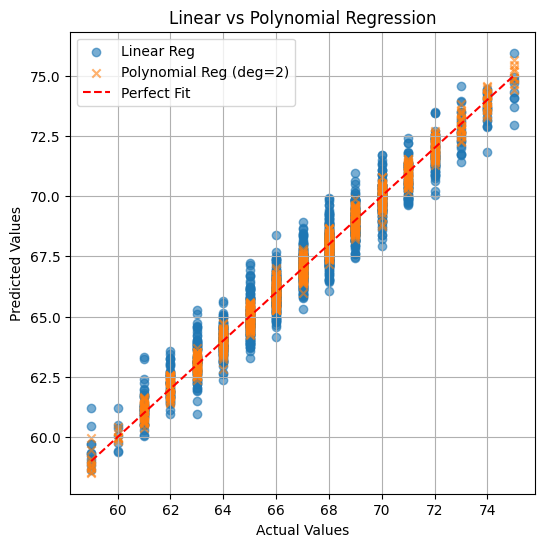

In [ ]:
plt.figure(figsize=(6, 6))
# Linear regression predictions
plt.scatter(y_test, y_pred, alpha=0.6, label="Linear Reg")
# Polynomial regression predictions
plt.scatter(y_test, y_pred_poly, alpha=0.6, label="Polynomial Reg (deg=2)", marker="x")
plt.plot([y_test.min(), y_test.max()],[y_test.min(), y_test.max()],"r--", label="Perfect Fit")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Linear vs Polynomial Regression")
plt.legend()
plt.grid(True)
plt.show()